Some demo (for division accuracy)

In [1]:
import numpy as np

c = np.float32(0.925924589693)
a = np.float32(8.9)
b = np.float32(c / a)
print('{0:10.16f}'.format(b))
print(a * b - c)

0.1040364727377892
-5.9604645e-08


In [2]:
a = np.array(5.0, dtype=np.float32)
b = np.sqrt(a)
print('{0:10.16f}'.format(b ** 2 - a))

0.0000001468220603


In [3]:
a = np.array(2.28827272710, dtype=np.float32)
b = np.exp(a)
print(np.log(b) - a)

0.0



- For some values the inverse functions give exact answers
- The relative accuracy should be kept due to the IEEE standard.
- Does not hold for many modern GPU.

## Loss of significance

Many operations lead to the loss of digits [loss of significance](https://en.wikipedia.org/wiki/Loss_of_significance)


For example, it is a bad idea to subtract two big numbers that are close, the difference will have fewer correct digits.

## Summation algorithm

However, the rounding errors can depend on the algorithm. 

Consider the simplest problem: given $n$ floating point numbers $x_1, \ldots, x_n$  

compute their sum

$$S = \sum_{i=1}^n x_i = x_1 + \ldots + x_n.$$

The simplest algorithm is to add one-by-one. 

What is the actual error for such algorithm? 

## Naive algorithm

Naive algorithm adds numbers one-by-one, 

$$y_1 = x_1, \quad y_2 = y_1 + x_2, \quad y_3 = y_2 + x_3, \ldots.$$

The worst-case error is then proportional to $\mathcal{O}(n)$, while **mean-squared** error is $\mathcal{O}(\sqrt{n})$.

The **Kahan algorithm** gives the worst-case error bound $\mathcal{O}(1)$ (i.e., independent of $n$).  

## Kahan summation
The following algorithm gives $2 \varepsilon + \mathcal{O}(n \varepsilon^2)$ error, where $\varepsilon$ is the machine precision.
```python
s = 0
c = 0
for i in range(len(x)):
    y = x[i] - c
    t = s + y
    c = (t - s) - y
    s = t
```

In [10]:
import math
from numba import jit


n = 10 ** 8
sm = 1e-10
x = np.ones(n, dtype=np.float32) * sm
x[0] = 1.0
true_sum = 1.0 + (n - 1)*sm
approx_sum = np.sum(x)
math_sum = math.fsum(x)


@jit
def dumb_sum2(x):
    s = np.float32(0.0)
    for i in range(len(x)):
        s = s + x[i]
    return s


@jit
def kahan_sum(x):
    s = np.float32(0.0)
    c = np.float32(0.0)
    for i in range(len(x)):
        y = x[i] - c
        t = s + y
        c = (t - s) - y
        s = t
    return s


k_sum = kahan_sum(x)
d_sum = dumb_sum2(x)
print(
    'Error in sum: {0:3.1e}, \nkahan: {1:3.1e}, \ndumb_sum: {2:3.1e}. '.format(
        approx_sum - true_sum,
        k_sum - true_sum,
        d_sum - true_sum,
        math_sum - true_sum))

Error in sum: 1.9e-04, 
kahan: -1.3e-07, 
dumb_sum: -1.0e-02. 


## More complicated example

In [5]:
import numpy as np
print(math.fsum([1, 1e20, 1, -1e20]), np.sum([1, 1e20, 1, -1e20]), 1 + 1e20 + 1 - 1e20)

2.0 0.0 0.0


## Summary of floating-point 
You should be really careful with floating point, since it may give you incorrect answers due to rounding-off errors.

For many standard algorithms, the stability is well-understood and problems can be easily detected.

## Vectors
We typically work not with **numbers**, but with **vectors**. 

Recall that a vector in a fixed basis of size $n$ can be represented as a 1D array with $n$ numbers. 

Typically, it is considered as an $n \times 1$ matrix (**column vector**).

**Example:** 
Polynomials with degree $\leq n$ form a linear space. 
Polynomial $ x^3 - 2x^2 + 1$ can be considered as a vector $\begin{bmatrix}1 \\ -2 \\ 0 \\ 1\end{bmatrix}$ in the basis $\{x^3, x^2, x, 1\}$.

## Vector norm
Vectors typically provide an (approximate) description of a physical (or some other) object. 

One of the main question is **how accurate** the approximation is (1%, 10%). 

What is an acceptable representation, of course, depends on the particular applications. For example:
- In partial differential equations accuracies $10^{-5} - 10^{-10}$ are the typical case
- In data mining sometimes an error of $80\%$ is ok, since the interesting signal is corrupted by a huge noise.

## Distances and norms
Norm is a **qualitative measure of smallness of a vector** and is typically denoted as $\Vert x \Vert$.

The norm should satisfy certain properties:

- $\Vert \alpha x \Vert = |\alpha| \Vert x \Vert$,
- $\Vert x + y \Vert \leq \Vert x \Vert + \Vert y \Vert$ (triangle inequality),
- If $\Vert x \Vert = 0$ then $x = 0$.

The distance between two vectors is then defined as
$$
   d(x, y) = \Vert x - y \Vert.
$$

## Standard norms
The most well-known and widely used norm is **euclidean norm**:
$$\Vert x \Vert_2 = \sqrt{\sum_{i=1}^n |x_i|^2},$$
which corresponds to the distance in our real life (the vectors might have complex elements, thus is the modulus here).

## $p$-norm
Euclidean norm, or $2$-norm, is a subclass of an important class of $p$-norms:
$$
 \Vert x \Vert_p = \Big(\sum_{i=1}^n |x_i|^p\Big)^{1/p}.
$$
There are two very important special cases:
- Infinity norm, or Chebyshev norm which is defined as the maximal element: $\Vert x \Vert_{\infty} = \max_i | x_i|$
- $L_1$ norm (or **Manhattan distance**) which is defined as the sum of modules of the elements of $x$: $\Vert x \Vert_1 = \sum_i |x_i|$ 


## Equivalence of the norms
All norms are equivalent in the sense that
$$
   C_1 \Vert x \Vert_* \leq  \Vert x \Vert_{**} \leq C_2 \Vert x \Vert_*
$$  
for some constants $C_1(n), C_2(n)$, $x \in \mathbb{R}^n$ for any pairs of norms $\Vert \cdot \Vert_*$ and $\Vert \cdot \Vert_{**}$. The equivalence of the norms basically means that if the vector is small in one norm, it is small in another norm. However, the constants can be large.

## Computing norms in Python
The numpy package has all you need for computing norms (```np.linalg.norm``` function)


In [6]:
import numpy as np
n = 100
a = np.ones(n)
b = a + 1e-3 * np.random.randn(n)
print('Relative error:', np.linalg.norm(a - b, np.inf) / np.linalg.norm(b, np.inf))

Relative error: 0.003005918880991518


## Unit disks in different norms
A unit disk is a set of points such that $\Vert x \Vert \leq 1$. For the 2nd norm is a disk; for other norms the "disks" look different.

Text(0.5, 1.0, 'Unit disk in the p-th norm, $p=inf$')

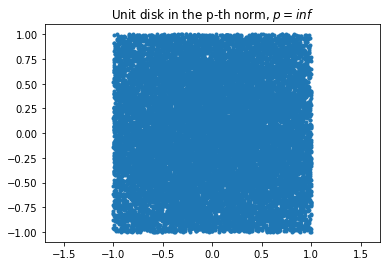

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
p = np.inf # Which norm do we use
M = 40000 # Number of sampling points
a = np.random.randn(M, 2)
b = []
for i in range(M):
    if np.linalg.norm(a[i, :], p) <= 1:
        b.append(a[i, :])
b = np.array(b)
plt.plot(b[:, 0], b[:, 1], '.')
plt.axis('equal')
plt.title('Unit disk in the p-th norm, $p={0:}$'.format(p))

## Why $L_1$-norm can be important
$L_1$ norm, as it was discovered quite recently, plays an important role in **compressed sensing**. 

The simplest formulation is as follows:
- You have some observations $f$ 
- You have a linear model $Ax = f$, where $A$ is an $n \times m$ matrix, $A$ is **known**
- The number of equations, $n$ is less than the number of unknowns, $m$

The question: can we find the solution?

The solution is obviously non-unique, so a natural approach is to find the solution that is minimal in the certain sense:

$$ \Vert x \Vert \rightarrow \min, \quad \mbox{subject to } Ax = f$$

Typical choice of $\Vert x \Vert = \Vert x \Vert_2$ leads to the **linear least squares problem** (and has been used for ages).  

The choice $\Vert x \Vert = \Vert x \Vert_1$ leads to the [**compressed sensing**]

(https://en.wikipedia.org/wiki/Compressed_sensing) and what happens, it typically yields the **sparsest solution**.  

## What is a stable algorithm?

And we finalize the lecture by the concept of **stability**.

Let $x$ be an object (for example, a vector). Let $f(x)$ be the function (functional) you want to evaluate.  

You also have a **numerical algorithm** ``alg(x)`` that actually computes **approximation** to $f(x)$.  

The algorithm is called **forward stable**, if $$\Vert alg(x) - f(x) \Vert  \leq \varepsilon $$  

The algorithm is called **backward stable**, if for any $x$ there is a close vector $x + \delta x$ such that

$$alg(x) = f(x + \delta x)$$

and $\Vert \delta x \Vert$ is small.

## Classical example
A classical example is the **solution of linear systems of equations** using LU-factorizations

We consider the **Hilbert matrix** with the elements

$$A = \{a_{ij}\}, \quad a_{ij} = \frac{1}{i + j + 1}, \quad i,j = 0, \ldots, n-1.$$

And consider a linear system

$$Ax = f.$$

In [8]:
import numpy as np

n = 500
a = [[1.0/(i + j + 1) for i in range(n)] for j in range(n)] #Hil
a = np.array(a)
rhs =  np.random.random(n)
sol = np.linalg.solve(a, rhs)
print(np.linalg.norm(a.dot(sol) - rhs)/np.linalg.norm(rhs)) #Ax - y
#plt.plot(sol)

11.65593914350935


In [9]:
rhs = np.ones(n)
sol = np.linalg.solve(a, rhs)
print(np.linalg.norm(a.dot(sol) - rhs)/np.linalg.norm(rhs)) #Ax - y
#plt.plot(sol)

2.0892044437853192e-07


## Take home message
- Floating point  (double, single, number of bytes), rounding error
- Norms are measures of smallness, used to compute the accuracy
- $1$, $p$ and Euclidean norms 
- $L_1$ is used in compressed sensing as a surrogate for sparsity
- Forward/backward error (and stability of algorithms)